# Bike-sharing forecasting

In this tutorial we're going to forecast the number of bikes in 5 bike stations from the city of Toulouse. We'll do so by building a simple model step by step. The dataset contains 182,470 observations. Let's first take a peak at the data.

In [1]:
from pprint import pprint
from river import datasets

X_y = datasets.Bikes()

for x, y in X_y:
    pprint(x)
    print(f'Number of available bikes: {y}')
    break

Uncompressing into /home/travis/river_data/Bikes
{'clouds': 75,
 'description': 'light rain',
 'humidity': 81,
 'moment': datetime.datetime(2016, 4, 1, 0, 0, 7),
 'pressure': 1017.0,
 'station': 'metro-canal-du-midi',
 'temperature': 6.54,
 'wind': 9.3}
Number of available bikes: 1


Let's start by using a simple linear regression on the numeric features. We can select the numeric features and discard the rest of the features using a `Select`. Linear regression is very likely to go haywire if we don't scale the data, so we'll use a `StandardScaler` to do just that. We'll evaluate the model by measuring the mean absolute error. Finally we'll print the score every 20,000 observations. 

In [2]:
from river import compose
from river import linear_model
from river import metrics
from river import evaluate
from river import preprocessing
from river import optim

X_y = datasets.Bikes()

model = compose.Select('clouds', 'humidity', 'pressure', 'temperature', 'wind')
model |= preprocessing.StandardScaler()
model |= linear_model.LinearRegression(optimizer=optim.SGD(0.001))

metric = metrics.MAE()

evaluate.progressive_val_score(X_y, model, metric, print_every=20_000)

[20,000] MAE: 4.912727
[40,000] MAE: 5.333554
[60,000] MAE: 5.330948
[80,000] MAE: 5.392313
[100,000] MAE: 5.423059
[120,000] MAE: 5.541223
[140,000] MAE: 5.613023
[160,000] MAE: 5.622428
[180,000] MAE: 5.567824


MAE: 5.563893

The model doesn't seem to be doing that well, but then again we didn't provide a lot of features. Generally, a good idea for this kind of problem is to look at an average of the previous values. For example, for each station we can look at the average number of bikes per hour. To do so we first have to extract the hour from the  `moment` field. We can then use a `TargetAgg` to aggregate the values of the target.

In [3]:
from river import feature_extraction
from river import stats

X_y = iter(datasets.Bikes())

def get_hour(x):
    x['hour'] = x['moment'].hour
    return x

model = compose.Select('clouds', 'humidity', 'pressure', 'temperature', 'wind')
model += (
    get_hour |
    feature_extraction.TargetAgg(by=['station', 'hour'], how=stats.Mean())
)
model |= preprocessing.StandardScaler()
model |= linear_model.LinearRegression(optimizer=optim.SGD(0.001))

metric = metrics.MAE()

evaluate.progressive_val_score(X_y, model, metric, print_every=20_000)

[20,000] MAE: 3.721246
[40,000] MAE: 3.829972
[60,000] MAE: 3.845068
[80,000] MAE: 3.910259
[100,000] MAE: 3.888652
[120,000] MAE: 3.923727
[140,000] MAE: 3.980953
[160,000] MAE: 3.950034
[180,000] MAE: 3.934545


MAE: 3.933498

By adding a single feature, we've managed to significantly reduce the mean absolute error. At this point you might think that the model is getting slightly complex, and is difficult to understand and test. Pipelines have the advantage of being terse, but they aren't always to debug. Thankfully `river` has some ways to relieve the pain.

The first thing we can do it to draw the pipeline, to get an idea of how the data flows through it.

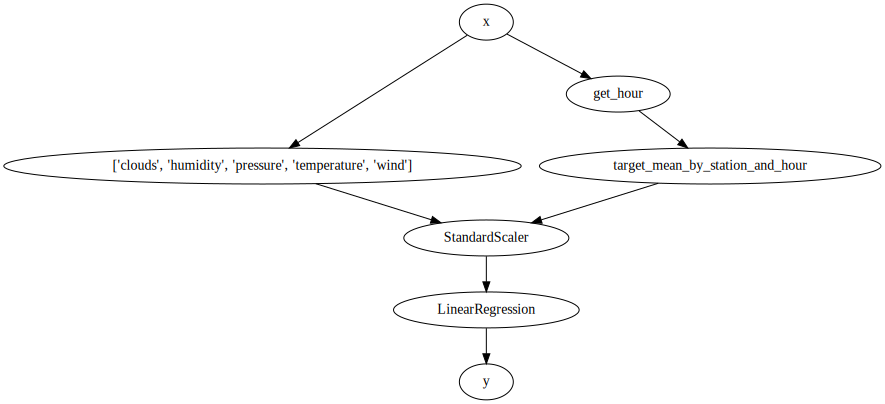

In [4]:
model.draw()

We can also use the `debug_one` method to see what happens to one particular instance. Let's train the model on the first 10,000 observations and then call `debug_one` on the next one. To do this, we will turn the `Bike` object into a Python generator with `iter()` function. The Pythonic way to read the first 10,000 elements of a generator is to use `itertools.islice`.

In [5]:
import itertools

X_y = iter(datasets.Bikes())

model = compose.Select('clouds', 'humidity', 'pressure', 'temperature', 'wind')
model += (
    get_hour |
    feature_extraction.TargetAgg(by=['station', 'hour'], how=stats.Mean())
)
model |= preprocessing.StandardScaler()
model |= linear_model.LinearRegression()

for x, y in itertools.islice(X_y, 10000):
    y_pred = model.predict_one(x)
    model.learn_one(x, y)
    
x, y = next(X_y)
print(model.debug_one(x))

0. Input
--------
clouds: 0 (int)
description: clear sky (str)
humidity: 52 (int)
moment: 2016-04-10 19:03:27 (datetime)
pressure: 1,001.00000 (float)
station: place-esquirol (str)
temperature: 19.00000 (float)
wind: 7.70000 (float)

1. Transformer union
--------------------
    1.0 Select
    ----------
    clouds: 0 (int)
    humidity: 52 (int)
    pressure: 1,001.00000 (float)
    temperature: 19.00000 (float)
    wind: 7.70000 (float)

    1.1 get_hour | target_mean_by_station_and_hour
    ----------------------------------------------
    target_mean_by_station_and_hour: 7.97175 (float)

clouds: 0 (int)
humidity: 52 (int)
pressure: 1,001.00000 (float)
target_mean_by_station_and_hour: 7.97175 (float)
temperature: 19.00000 (float)
wind: 7.70000 (float)

2. StandardScaler
-----------------
clouds: -1.36138 (float)
humidity: -1.73083 (float)
pressure: -1.26076 (float)
target_mean_by_station_and_hour: 0.05496 (float)
temperature: 1.76232 (float)
wind: 1.45841 (float)

3. LinearRegressi

The `debug_one` method shows what happens to an input set of features, step by step.

And now comes the catch. Up until now we've been using the `progressive_val_score` method from the `evaluate` module. What this does it that it sequentially predicts the output of an observation and updates the model immediately afterwards. This way of doing is often used for evaluating online learning models, but in some cases it is the wrong approach.

The following paragraph is extremely important. When evaluating a machine learning model, the goal is to simulate production conditions in order to get a trust-worthy assessment of the performance of the model. In our case, we typically want to forecast the number of bikes available in a station, say, 30 minutes ahead. Then, once the 30 minutes have passed, the true number of available bikes will be available and we will be able to update the model using the features available 30 minutes ago. If you think about, this is exactly how a real-time machine learning system should work. The problem is that this isn't what the `progressive_val_score` method is emulating, indeed it is simply asking the model to predict the next observation, which is only a few minutes ahead, and then updates the model immediately. We can prove that this is flawed by adding a feature that measures a running average of the very recent values.

In [6]:
X_y = datasets.Bikes()

model = compose.Select('clouds', 'humidity', 'pressure', 'temperature', 'wind')
model += (
    get_hour |
    feature_extraction.TargetAgg(by=['station', 'hour'], how=stats.Mean()) + 
    feature_extraction.TargetAgg(by='station', how=stats.EWMean(0.5))
)
model |= preprocessing.StandardScaler()
model |= linear_model.LinearRegression()

metric = metrics.MAE()

evaluate.progressive_val_score(X_y, model, metric, print_every=20_000)

[20,000] MAE: 20.159286
[40,000] MAE: 10.458898
[60,000] MAE: 7.2759
[80,000] MAE: 5.715397
[100,000] MAE: 4.775094
[120,000] MAE: 4.138421
[140,000] MAE: 3.682591
[160,000] MAE: 3.35015
[180,000] MAE: 3.091398


MAE: 3.06414

The score we got is too good to be true. This is simply because the problem is too easy. What we really want is to evaluate the model by forecasting 30 minutes ahead and only updating the model once the true values are available. This can be done using the `moment` and `delay` parameters in the  `progressive_val_score` method. The idea is that each observation of the stream of the data is shown twice to the model: once for making a prediction, and once for updating the model when the true value is revealed. The `moment` parameter determines which variable should be used as a timestamp, while the `delay` parameter controls the duration to wait before revealing the true values to the model.

In [7]:
import datetime as dt

model = compose.Select('clouds', 'humidity', 'pressure', 'temperature', 'wind')
model += (
    get_hour |
    feature_extraction.TargetAgg(by=['station', 'hour'], how=stats.Mean()) + 
    feature_extraction.TargetAgg(by='station', how=stats.EWMean(0.5))
)
model |= preprocessing.StandardScaler()
model |= linear_model.LinearRegression()

evaluate.progressive_val_score(
    dataset=datasets.Bikes(),
    model=model,
    metric=metrics.MAE(),
    moment='moment',
    delay=dt.timedelta(minutes=30),
    print_every=20_000
)

[20,000] MAE: 2.24812
[40,000] MAE: 2.240287
[60,000] MAE: 2.270287
[80,000] MAE: 2.28649
[100,000] MAE: 2.294264
[120,000] MAE: 2.275891
[140,000] MAE: 2.261411
[160,000] MAE: 2.285978
[180,000] MAE: 2.289353


MAE: 2.29304

The score we now have is much more realistic, as it is comparable with the [related data science competition](https://maxhalford.github.io/blog/openbikes-challenge/). Moreover, we can see that the model gets better with time, which feels better than the previous situations. The point is that `progressive_val_score` method can be used to simulate a production scenario, and is thus extremely valuable.

Now that we have a working pipeline in place, we can attempt to make it more accurate. As a simple example, we'll using a `EWARegressor` from the `expert` module to combine 3 linear regression model trained with different optimizers. The `EWARegressor` will run the 3 models in parallel and assign weights to each model based on their individual performance.

In [8]:
from river import expert
from river import optim

model = compose.Select('clouds', 'humidity', 'pressure', 'temperature', 'wind')
model += (
    get_hour |
    feature_extraction.TargetAgg(by=['station', 'hour'], how=stats.Mean())
)
model += feature_extraction.TargetAgg(by='station', how=stats.EWMean(0.5))
model |= preprocessing.StandardScaler()
model |= expert.EWARegressor([
    linear_model.LinearRegression(optim.SGD()),
    linear_model.LinearRegression(optim.RMSProp()),
    linear_model.LinearRegression(optim.Adam())
])

evaluate.progressive_val_score(
    dataset=datasets.Bikes(),
    model=model,
    metric=metrics.MAE(),
    moment='moment',
    delay=dt.timedelta(minutes=30),
    print_every=20_000
)

[20,000] MAE: 2.253263
[40,000] MAE: 2.242859
[60,000] MAE: 2.272001
[80,000] MAE: 2.287776
[100,000] MAE: 2.295292
[120,000] MAE: 2.276748
[140,000] MAE: 2.262146
[160,000] MAE: 2.286621
[180,000] MAE: 2.289925


MAE: 2.293604